# Class

In [2]:
from threading import Thread
from multiprocessing import Process
import time
import datetime
import socket
import itertools
import json

%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import pandas as pd
from IPython.display import clear_output

import logging
logging.basicConfig(level=logging.INFO)

# Main Branch

In [ ]:
class EEGStream:
    def __init__(self, channels=8, sampling_rate=222, fps=25, time_window=1000):
        
        self.channels = channels      
        self.sampling_rate = sampling_rate                     
        self.fps = fps                      
        self.time_window=time_window                  
        self.xwindow = int(time_window/1000*sampling_rate)  
        
        # DataFrame with columns ["time","ch1",..,"ch8", "sampling_rate"]
        self.data = pd.DataFrame({"time" if i == 0 else\
                                   f"{i}" if i <= self.channels else\
                                   "sampling_rate":pd.Series([],dtype="float64")
                                   for i in range(0,self.channels+2) })
        
        self.plotting = False

                                #=== 'MAIN' FUNCTION ===#
        
    def start(self):
        '''
        Starts a thread for plotting and starts listening to the socketstream
        '''

        #recording_thread = Thread(target=self.record,daemon=False)
        #recording_thread.start()
        self.animate_plot()
        
        #recording_thread.join() # Wait for the thread to end properly
        

        if input("Stream Again? | 'y' for 'yes'") == 'y':
            self.start()
            clear_output()
        else:
            return
    
                                #=== PLOT RELATED FUNCTIONS ===#
    
    
    def animate_plot(self):
        self.plotting=True
        # Waiting for Data
        logging.info("Accumulating enough data for streaming..")
        
        # Plot Items
        channels = [str(i) for i in range(1,self.channels)]
        self.data.plot(x="time", y=channels)
        self.fig = plt.gcf()
        self.ax = self.fig.gca()
        self.lines = [line for line in self.ax.lines]
        
        
        logging.info("Reached FuncAnimation")
        self.animation = FuncAnimation(self.fig, self.update_lines, interval=1000/self.fps)
        
    def update_lines(self, frame):
        logging.info("Update Lines Was Called")
        data = pd.read_csv("sessions/temp/plot_data.csv")

        for i,line in enumerate(self.lines):
            line.set_data(data.time, data[f"{i+1}"])

        self.fig.gca().relim()
        self.fig.gca().autoscale_view()

        return self.lines
    
                          #=== SOCKET STREAMING RELATED FUNCTIONS ===#
        
                    
    def build_connection(self,host="",port=65432):
        '''
        Creates a UDP Socket and waits for a connection with the specified parameters.
        
        returns
        ss : streaming socket
        connection 
        '''
        ss = socket.socket(socket.AF_INET, socket.SOCK_STREAM)

        try:
            # reuse address:port if on use
            # otherwise process needs to be killed if socket wasn't closed
            ss.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
            ss.bind((host, port))  # associate the socket with an address and port
        except socket.error as e:
            print(str(e))

        print("Waiting for a Connection..")

        ss.listen()  # listening socket, ready to accept connections

        connection, address = ss.accept()  # wait for incoming connections
        ip = address[0]  # socket sender IP
        port = address[1]  # socket sender port
        print(f"Connected to {ip}:{port}")
        self.socket = ss
        return ss, connection

    def record(self, buffersize=1):
        '''
        Builds a connection, reads data from it and creates packages in the form of dictionaries.
        Expects incoming data to be stringified json files. 
        '''
        
        socket, connection = self.build_connection()
        
        pkg = ""        # 1 pkg: 1 json object
        pkg_count = 0
        empty_msgs = 0  # counter

        start_time = time.time()
        sampling_rate = 0 
        
        # loop for handling incoming data
        while True:  

            # Receive data (buffer length=1byte)
            response = connection.recv(buffersize).decode("utf-8")   

            # Count Empty Responses
            if not response: 
                empty_msgs += 1  
                if empty_msgs > 10000: break

            # Beginning of Package
            if response[0] == "{":  
                pkg += response  # add to chunk
                empty_msgs = 0   # reset counter

            # Content
            elif "}" not in response: 
                pkg += response

            # End of Package 
            else:
                
                pkg_count += 1
                pkg += response
               
                elapsed = int((time.time() - start_time)*1e3)
                json_string = pkg.rstrip("\n").strip() # remove ending break lines and white spaces
                current = json.loads(json_string)  # parse stringified JSON as dict
                
                sampling_rate = int(pkg_count / elapsed) if pkg_count > 1 else 0.001
                
                self.store(elapsed,current,sampling_rate)  # add current read package for plotting 
                empty_msgs = 0
                
                pkg = pkg[pkg.index("}")+1:]  # only keep data after the end of the first package
                
                if pkg_count > 2000: break

        socket.close()  # disconnect listening socket
        logging.info("Ended Streaming Session")
        
        # Save Data
        if input("Save Recorded data?  | 'y' for 'yes'") == 'y':
            self.to_csv() 
        return
        
                                        #=== STORAGE RELATED FUNCTIONS ===#
    def store(self, elapsed, current, sampling_rate):
        '''
        Rearranges incoming data into a dictionary of the following form
        
            'time':elapsed,
            '1':mV1, 
            |...
            '8':mV8,
            'sampling_rate':sampling_rate
            
        '''
        datadic = {**{'time':elapsed}, **current, **{'sampling_rate':sampling_rate}}
        self.data = self.data.append(datadic, ignore_index=True)
        
        if self.plotting:
            try:
                self.data[-self.xwindow:].to_csv("sessions/temp/plot_data.csv")
            except:
                logging.debug("Permission file, file used by another service")
                pass
    def to_csv(self):
        time = datetime.datetime.now().strftime("%Y-%m-%d-%H%M")
        filepath = f"sessions/{time}.csv"
        self.data.to_csv(filepath)
        print(f"Data saved to {filepath}")

# Testing Branch

<IPython.core.display.Javascript object>


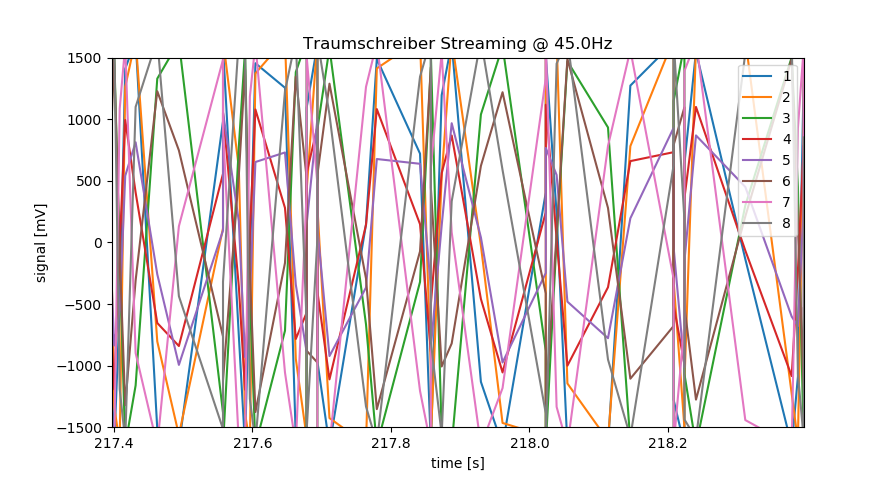

In [3]:

'''necessary globals due to pecularities of matplotlib for live plotting'''

channels = 8
# Empty dataframe with columns ["time","ch1",..,"ch8", "sampling_rate"]
df = pd.DataFrame({"time" if i == 0 else\
                   f"{i}" if i <= channels else\
                   "sampling_rate":pd.Series([],dtype="float64")
                   for i in range(0,channels+2) })

channels = [str(i+1) for i in range(channels)]
df.plot(x="time", y=channels)
fig = plt.gcf()
ax = fig.gca()
lines = [line for line in ax.lines]

fig.gca().set_ylim(-1500,1500)
fig.gca().set_xlabel("time [s]")
fig.gca().set_ylabel("signal [mV]")

pkg = 225
time_window=1
xwindow=int(220*time_window)

recording = False
class EEGStream:
    
    def __init__(self):
        global df
        self.data = df
    def live_plot(self):
        '''
        Starts a thread for plotting and starts listening to the socketstream
        '''
        global fig,plot, recording
        self.plotting = True
        recording = False
        
        plt.show()
        recording_thread = Thread(target=self.record,daemon=False)
        recording_thread.start()
        #recording_thread.join() # Wait for the thread to end properly
        logging.info("Waiting for incoming data..")
        while not recording:
            time.sleep(0.5)
        self.animate_plot()

        if input("Stream Again? | 'y' for 'yes'") == 'y':
            self.live_plot()
            clear_output()
        else:
            return
    
                                #=== PLOT RELATED FUNCTIONS ===#
        
    def animate_plot(self):
        global fig, pkg, recording
        pkg = 225
        
        # Waiting for Data
        logging.info("Accumulating enough data for streaming..")
        time.sleep(5)
        while recording:
            time.sleep(0.05)
            self.update_lines()
            fig.canvas.draw()
        
        return 
    
    def update_lines(self):
        global fig, lines, xwindow, pkg
        #data = pd.read_csv("sessions/temp/plot_data.csv")
        try:
            data = pd.read_csv("sessions/temp/plot_data.csv")
        except:
            return
        for i,line in enumerate(lines):
            line.set_data(data.time, data[f"{i+1}"])

        right = data.time.iloc[-1]
        left = right-1
        fig.gca().set_xlim(left,right)
        fig.gca().set_title(f"Traumschreiber Streaming @ {data.sampling_rate.iloc[-1]}Hz")
        
        fig.gca().autoscale_view()
        fig.gca().legend(loc="upper right")
        
        pkg += 1

        return 

    
                          #=== SOCKET STREAMING RELATED FUNCTIONS ===#
        
                    
    def build_connection(self,host="",port=65432):
        '''
        Creates a UDP Socket and waits for a connection with the specified parameters.
        
        returns
        ss : streaming socket
        connection 
        '''
        ss = socket.socket(socket.AF_INET, socket.SOCK_STREAM)

        try:
            # reuse address:port if on use
            # otherwise process needs to be killed if socket wasn't closed
            ss.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
            ss.bind((host, port))  # associate the socket with an address and port
        except socket.error as e:
            print(str(e))

        print("Waiting for a Connection..")

        ss.listen()  # listening socket, ready to accept connections

        connection, address = ss.accept()  # wait for incoming connections
        ip = address[0]  # socket sender IP
        port = address[1]  # socket sender port
        print(f"Connected to {ip}:{port}")
        self.socket = ss
        return ss, connection

    def record(self, buffersize=1):
        '''
        Builds a connection, reads data from it and creates packages in the form of dictionaries.
        Expects incoming data to be stringified json files. 
        '''
        global recording
        recording = True
        socket, connection = self.build_connection()
        
        pkg = ""        # 1 pkg: 1 json object
        pkg_count = 0
        empty_msgs = 0  # counter

        start_time = time.time()
        sampling_rate = 0 
        
        # loop for handling incoming data
        while True:  

            # Receive data (buffer length=1byte)
            response = connection.recv(buffersize).decode("utf-8")   

            # Count Empty Responses
            if not response: 
                empty_msgs += 1  
                if empty_msgs > 10000: break

            # Beginning of Package
            if response[0] == "{":  
                pkg += response  # add to chunk
                empty_msgs = 0   # reset counter

            # Content
            elif "}" not in response: 
                pkg += response

            # End of Package 
            else:
                
                pkg_count += 1
                pkg += response
               
                elapsed = (time.time() - start_time)
                json_string = pkg.rstrip("\n").strip() # remove ending break lines and white spaces
                current = json.loads(json_string)  # parse stringified JSON as dict
                
                sampling_rate = int(pkg_count / elapsed) if pkg_count > 1 else 0.001
                
                self.store(elapsed,current,sampling_rate)  # add current read package for plotting 
                empty_msgs = 0
                
                pkg = pkg[pkg.index("}")+1:]  # only keep data after the end of the first package
                
                if pkg_count > 10000: break

        socket.close()  # disconnect listening socket
        logging.info("Ended Streaming Session")
        recording = False
        # Save Data
        if input("Save Recorded data?  | 'y' for 'yes'") == 'y':
            self.to_csv() 
        return
        
                                        #=== STORAGE RELATED FUNCTIONS ===#
    def store(self, elapsed, current, sampling_rate):
        global xwindow
        '''
        Rearranges incoming data into a dictionary of the following form
        
            'time':elapsed,
            '1':mV1, 
            |...
            '8':mV8,
            'sampling_rate':sampling_rate
            
        '''
        del current["time"]
        #logging.info(f"Elapsed: {elapsed}")
        datadic = {**{'time':elapsed}, **current, **{'sampling_rate':sampling_rate}}
        self.data = self.data.append(datadic, ignore_index=True)
        if self.data.shape[0] > xwindow+20:
            self.data[-xwindow-10:].to_csv("sessions/temp/plot_data.csv")
              
    def to_csv(self):
        time = datetime.datetime.now().strftime("%Y-%m-%d-%H%M")
        filepath = f"sessions/{time}.csv"
        self.data.to_csv(filepath)
        print(f"Data saved to {filepath}")
        

In [4]:
EEGStream().live_plot()

INFO:root:Waiting for incoming data..
INFO:root:Accumulating enough data for streaming..


Waiting for a Connection..
Connected to 192.168.0.105:38833


INFO:root:Ended Streaming Session


Save Recorded data?  | 'y' for 'yes'y
Stream Again? | 'y' for 'yes'n


# Working Animated Plot - Experimenting with plot animation

In [ ]:
from threading import Thread
import time
import datetime
import socket
import itertools
import json

%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import pandas as pd
from IPython.display import clear_output

import logging
logging.basicConfig(level=logging.INFO)
logging.disable(level=logging.DEBUG)




channels = 8
pkg = 201
data = pd.read_csv("sessions/2020-05-30-1510.csv")

cls = [str(i) for i in range(1,channels)]
data[1:1].plot(x="time", y=cls)
fig = plt.gcf()
ax = fig.gca()
lines = [line for line in ax.lines]

class yo:
 
    def update_plot():
        global pkg, fig, lines
        data = pd.read_csv("sessions/2020-05-30-1510.csv")
        data = data[pkg-50:pkg]

        for i,line in enumerate(lines):
            line.set_data(data.time, data[f"{i+1}"])

        left = data.time[pkg-50]
        right = data.time[pkg-10]
        fig.gca().set_xlim(left,right)
        fig.gca().set_ylim(-1500,1500)
        fig.gca().autoscale_view()
        fig.gca().legend(loc="upper right")
        pkg += 1

        return lines
    
    def animate(self):
        global fig
        #animation = FuncAnimation(fig, yo.update_lines, interval=300, blit=True)
        
        for i in range(100):
            time.sleep(0.05)
            yo.update_plot()
            fig.canvas.draw()
        return 
            
    def another():
        
        for i in range(10):
            time.sleep(1)
            print("WORKS, BITCH")

animation = Thread(target=yo().animate)
animation.start()
yo.another()

In [ ]:
class plotter:
    def plot_from_file()
        

# Complete

In [ ]:
# constants
CHANNELS = 8  # number of eeg channels
PLOT_MEMO = 0.5  # plot memory in seconds
SR = 222  # expected sampling rate/frequency (Hz): N/elapsed_time
SI = 4.5  # expected sampling interval (ms): 1/SR
C_SR = True  # set constant or not constant sampling rate


## Plot definiton
fig = plt.gcf()
plt.ion()  # not sure if necessary, also works without
plt.style.use("ggplot")  # use ggplot style

# color iterable from a color map
color = itertools.cycle(plt.get_cmap("tab10").colors)

# prepare the lines to plot with their labels and colors
for i in range(CHANNELS):
    c = next(color)  # get next color from the palette (color map)
    plt.plot([],[], color=c, linewidth=0.6, linestyle="-", label=f"ch-{i + 1}")

ax = plt.gca()  # get axis
box = ax.get_position()  # box position to shrink axis
lines = [line for line in ax.lines]  # unpack the lines

# manually set visible y-axis limits
ax.set_ylim(-2000, 2000)  # can also be updated according to min/max amplitude
plt.tight_layout()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))  # legend position
plt.xlabel("Time (s)")
plt.ylabel("Voltage (μV)")
fig.show()


# dict to organize the data to plot into lines
"""
Example:
    eeg = {
        "time": [timestamps]
        "ch-1": { "series": [ch-1 amplitudes] }
        "ch-2": { "series": [ch-2 amplitudes] }
        ...
    }
"""
eeg = {f"ch-{i + 1}": {"series": []} for i in range(CHANNELS)}
eeg["time"] = []


# vars to manipulate while plotting
c_time = 0
first = 0

def update_lines(xwindow=1000):
    global lines, SI
    
    # That means xwindow/2 / c_si
    windowsize= int(xwindow / SI)
    
    logging.debug(f"Len of eeg[time]: {len(eeg['time'])} windowsize: {windowsize}")
    if len(eeg["time"]) <= windowsize:
        return
    times = eeg["time"][-windowsize:]
    
     
    for i in range(CHANNELS):
        key = f"ch-{i+1}" # selected amplitude values
        series = eeg[key]["series"][-windowsize:]
        lines[i].set_data(times, series)  # update lines time-series data
    
    # shrink current axis by 5% to place legend out of plot box
    ax.set_position([box.x0, box.y0, box.width * 0.95, box.height])
    # ax.set_ylim(ymin - EXTRA_YLIM, ymax + EXTRA_YLIM)
    
    plt.title(f"Traumschreiber EEG streaming @ {sampling_rate} Hz")
    # recompute the ax.dataLim
    ax.relim()
    # update ax.viewLim using the new dataLim
    ax.autoscale_view(True, True, True)
    fig.canvas.draw()
    fig.canvas.flush_events()

def store_data(ddict, constant=False):
    global first, c_time
    # organize the data to plot a line per channel
    if not constant:
        timestamp = ddict["time"] / 1000  # get timestamp in s
        if first == 0:  # first timestamp
            first = timestamp  # store it for time reference
        # calculate time relative to first timestamp (so starting at 0)
        time = timestamp - first
    else:
        # assuming constant sampling interval
        c_time += SI / 1000
        time = c_time
    eeg["time"].append(time)  # add time
    
    
    for i in range(CHANNELS):  # each channel
        key = str(i + 1)  # as keys on eeg are 1-8
        series = ddict[key]  # eeg amplitude value
        eeg[f"ch-{key}"]["series"].append(series)  # add eeg amplitude
    # call update plot when packages >= 111 (expected samples in 0.5s)
    if len(eeg["time"]) >= SR / 2:
        update_lines()

def build_connection(host="",port=65432):
    ss = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    try:
        # reuse address:port if on use
        # otherwise process needs to be killed if socket wasn't closed
        ss.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
        ss.bind((host, port))  # associate the socket with an address and port
    except socket.error as e:
        print(str(e))
        
    print("Waiting for a Connection..")
    ss.listen()  # listening socket, ready to accept connections

    c, address = ss.accept()  # wait for incoming connections
    ip = address[0]  # socket sender IP
    port = address[1]  # socket sender port
    print(f"Connected to {ip}:{port}")
    
    return ss,c


ss,c = build_connection()


# vars to handle the receiving data loop
pkg = ""        # 1 pkg: 1 json object
pkg_count = 0
empty_msgs = 0  # counter for empty messages

# starting time reference for elapsed time and sampling rate calculations
t_start = None
sampling_rate = 0 

# loop for handling incoming data
while True:  
    
    # Set Start Time
    if not t_start:  # reference timestamp not set
        t_start = time.time()  # reference timestamp (ms)
     
    # Receive data (buffer length=1byte)
    response = c.recv(1).decode("utf-8")   
        
    # Count Empty Responses
    if not response: 
        empty_msgs += 1  # increase empty response count   
        if empty_msgs > 10000: break
               
    # Beginning of Package
    if response == "{":  
        pkg += response  # add to chunk
        empty_msgs = 0   # reset counter
        
    # Content
    elif response != "}": 
        pkg += response
        
    # End of Package 
    else:
        pkg_count += 1
        pkg += response

        json_string = pkg.rstrip("\n").strip() # remove ending break lines and white spaces
        current = json.loads(json_string)  # parse stringified JSON as dict
        store_data(current, C_SR)  # add current read package for plotting

        elapsed = time.time() - t_start
        sampling_rate = int(pkg_count  / elapsed) 

        logging.info(current)  # current received data {pkg, time, ch1-8}
        
        empty_msgs = 0
        pkg = ""  # clear accumulated chunks

ss.close()  # disconnect listening socket
print("Socket closed")